# Challenge Avanzado - Maestría en Ciencia de Datos
## Héctor Gabriel Sánchez Pérez

## Contexto del Proyecto

### 📊 ¿De qué trata este proyecto?

Este notebook presenta un **pipeline completo de Machine Learning** para **predicción de precios de acciones** utilizando datos financieros en tiempo real, combinando las capacidades de **PySpark** para procesamiento distribuido de grandes volúmenes de datos con **PyCaret** para modelado automático de aprendizaje automático.

### 🎯 Objetivo Principal

Desarrollar un modelo predictivo robusto que pueda **anticipar el precio de cierre** de acciones de Microsoft (MSFT) basándose en datos históricos intraday (minuto a minuto), utilizando técnicas avanzadas de:
- **Feature Engineering** con Window Functions de Spark
- **AutoML** con PyCaret para comparación automática de múltiples algoritmos
- **Análisis de streaming** simulado para procesamiento de datos en tiempo real

### 🔧 ¿Qué se desarrolla en este notebook?

Este proyecto implementa un flujo de trabajo completo que incluye:

1. **Adquisición de Datos**: Descarga de datos financieros reales de MSFT usando la API de yfinance (7 días, intervalo de 1 minuto)

2. **Procesamiento Distribuido con PySpark**:
   - Conversión de datos a formato Spark para escalabilidad
   - Persistencia en Databricks para reproducibilidad
   - Feature Engineering distribuido usando Window Functions

3. **Análisis Exploratorio (EDA)**:
   - Detección de outliers y patrones anómalos
   - Análisis de correlaciones entre variables
   - Visualización de tendencias temporales

4. **Modelado Predictivo con PyCaret**:
   - Comparación automática de 15+ algoritmos de regresión
   - Selección del mejor modelo basado en RMSE
   - Evaluación exhaustiva con múltiples métricas (R², RMSE, MAE, MAPE)

5. **Spark Streaming**:
   - Simulación de procesamiento en tiempo real con ventanas deslizantes
   - Agregaciones temporales de 30 minutos con desplazamiento de 10 minutos
   - Visualización de métricas por ventanas de tiempo

6. **Evaluación y Validación**:
   - Gráficas de diagnóstico (residuos, errores, importancia de features)
   - Análisis de predicciones vs valores reales
   - Interpretación detallada de resultados

### 📈 Aplicación Práctica

Este notebook es relevante para:
- **Trading algorítmico**: Predicción de precios para decisiones de compra/venta
- **Gestión de riesgo**: Monitoreo de volatilidad y tendencias
- **Análisis cuantitativo**: Identificación de patrones en series temporales financieras
- **Big Data en finanzas**: Procesamiento escalable de grandes volúmenes de datos de mercado

### 🎓 Contexto Académico

Desarrollado como parte del **Challenge Avanzado** de la Maestría en Ciencia de Datos, este proyecto demuestra el uso de tecnologías modernas (Databricks Serverless, PySpark, AutoML) aplicadas a un problema real del mundo financiero.

# 0. Initialize Spark Session in Databricks

**IMPORTANTE:** 
- **Si ejecutas en Databricks directamente**: Comenta o elimina esta celda. La sesión `spark` ya está disponible automáticamente.
- **Si ejecutas localmente con databricks-connect**: Ejecuta esta celda para conectarte a Databricks serverless.

### Conexión a Databricks Serverless

Esta celda establece la conexión con Databricks usando `databricks-connect`. Lee la configuración desde `~/.databrickscfg` y crea una sesión Spark en modo serverless. Incluye manejo de errores para reconectar automáticamente si hay variables de entorno conflictivas.

In [44]:
from databricks.connect import DatabricksSession
import os

def reconnect_spark(force_stop=True):
    """
    Reconecta a Databricks limpiando el caché de sesión.
    
    Args:
        force_stop: Si es True, intenta cerrar la sesión anterior
    
    Returns:
        SparkSession: Sesión de Spark conectada a Databricks
    """
    global spark
    
    # 1. Cerrar sesión anterior si existe
    if force_stop:
        try:
            if 'spark' in globals():
                spark.stop()
                print("✓ Sesión anterior cerrada")
        except Exception as e:
            print(f"⚠ Error cerrando sesión: {e}")
    
    # 2. Limpiar variables de entorno que causan conflictos
    env_vars_to_remove = [
        'DATABRICKS_AUTH_TYPE',
        'DATABRICKS_METADATA_SERVICE_URL',
        'DATABRICKS_SERVERLESS_COMPUTE_ID',
        'SPARK_REMOTE'
    ]
    
    for var in env_vars_to_remove:
        os.environ.pop(var, None)
    
    # 3. Crear nueva sesión
    spark = (DatabricksSession.builder
             .profile("DEFAULT")
             .serverless(True)
             .getOrCreate())
    
    print(f"✓ Reconectado exitosamente - Spark v{spark.version}")
    return spark

# Intentar conexión inicial
try:
    spark = (DatabricksSession.builder
             .profile("DEFAULT")
             .serverless(True)
             .getOrCreate())
    
    print(f"✓ Connected! Spark version: {spark.version}")
    
except Exception as e:
    error_msg = str(e)
    
    # Detectar error de sesión expirada
    if "session_id is no longer usable" in error_msg or "INACTIVITY_TIMEOUT" in error_msg:
        print(f"⚠ Sesión expirada detectada. Reconectando...")
        spark = reconnect_spark(force_stop=True)
    else:
        print(f"⚠ Error conectando: {e}")
        print("Intentando reconexión con limpieza completa...")
        spark = reconnect_spark(force_stop=True)

✓ Connected! Spark version: 4.0.0


### 💡 Tip: Reconexión Manual

Si en algún momento durante la ejecución del notebook obtienes el error:
```
SparkConnectGrpcException: session_id is no longer usable [reason=INACTIVITY_TIMEOUT]
```

Simplemente ejecuta esta celda para reconectar:
```python
spark = reconnect_spark(force_stop=True)
```

La función `reconnect_spark()` está disponible en esta sesión y maneja automáticamente:
- ✓ Cierre de sesión anterior
- ✓ Limpieza de variables de entorno conflictivas
- ✓ Creación de nueva sesión limpia

In [45]:
# 🔄 Ejecuta esta celda si necesitas reconectar manualmente
# (Después de inactividad, timeouts, o errores de sesión)

# spark = reconnect_spark(force_stop=True)

## 1. Importación de Librerías y Configuración

### Importación de Librerías Esenciales

Se importan las librerías necesarias para todo el pipeline:
- **PySpark SQL**: Para operaciones distribuidas en DataFrames
- **PySpark ML**: Para machine learning (pipelines, feature engineering)
- **Matplotlib & Seaborn**: Para visualizaciones
- **Pandas & NumPy**: Para manipulación de datos

In [46]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, isnan, mean, stddev, corr
from pyspark.sql.types import DoubleType

from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Configuración de visualización
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [47]:
# Imprimir Versión de Spark
import pyspark
print(f"Spark Version: {pyspark.__version__}")

Spark Version: 3.5.2


## 2. Descarga de Datos con yfinance

En esta celda descargaremos datos intraday de MSFT (últimos 7 días con intervalo de 1 minuto):

1. **Descarga por símbolo**: Usamos un bucle para descargar datos históricos usando `yfinance.Ticker.history()`
2. **Combinación de datos**: Concatenamos múltiples DataFrames de Pandas en un solo DataFrame
3. **Limpieza de columnas**: yfinance genera una columna 'Datetime' al hacer `reset_index()` que renombramos a 'timestamp' para consistencia
4. **Ordenamiento temporal**: Ordenamos por timestamp (ascendente) para asegurar orden cronológico correcto en análisis posteriores

El resultado será un DataFrame con ~2,729 registros de precios (Open, High, Low, Close, Volume) minuto a minuto.

In [48]:
import yfinance as yf
from datetime import datetime, timedelta

# Símbolos de acciones tecnológicas
symbols = ['MSFT']

# Descargar datos de últimos 7 días con intervalo de 1 minuto
data_dict = {}
for symbol in symbols:
    ticker = yf.Ticker(symbol)
    df = ticker.history(period='7d', interval='1m')
    df['symbol'] = symbol
    data_dict[symbol] = df
    print(f"{symbol}: {len(df)} registros")

# Combinar todos los datos
import pandas as pd
df_combined = pd.concat(data_dict.values(), ignore_index=False)
df_combined = df_combined.reset_index()
# yfinance crea la columna 'Datetime' al hacer reset_index()
df_combined.rename(columns={'Datetime': 'timestamp'}, inplace=True)

# Ordenar por timestamp de manera ascendente para asegurar orden cronológico
df_combined = df_combined.sort_values('timestamp').reset_index(drop=True)

print(f"\nTotal de registros: {len(df_combined)}")
df_combined.head()

MSFT: 2729 registros

Total de registros: 2729


,timestamp,Open,High,Low,Close,Volume,Dividends,Stock Splits,symbol
0,2025-11-13 09:30:00-05:00,510.309998,511.519989,509.500000,511.100006,2131380,0.0,0.0,MSFT
1,2025-11-13 09:31:00-05:00,511.089996,511.579987,510.510010,510.750000,42078,0.0,0.0,MSFT
2,2025-11-13 09:32:00-05:00,510.679993,510.779999,510.000000,510.579987,45196,0.0,0.0,MSFT
3,2025-11-13 09:33:00-05:00,510.579987,511.179993,510.429993,510.790009,32077,0.0,0.0,MSFT
4,2025-11-13 09:34:00-05:00,510.790009,510.950012,510.000000,510.170013,35423,0.0,0.0,MSFT


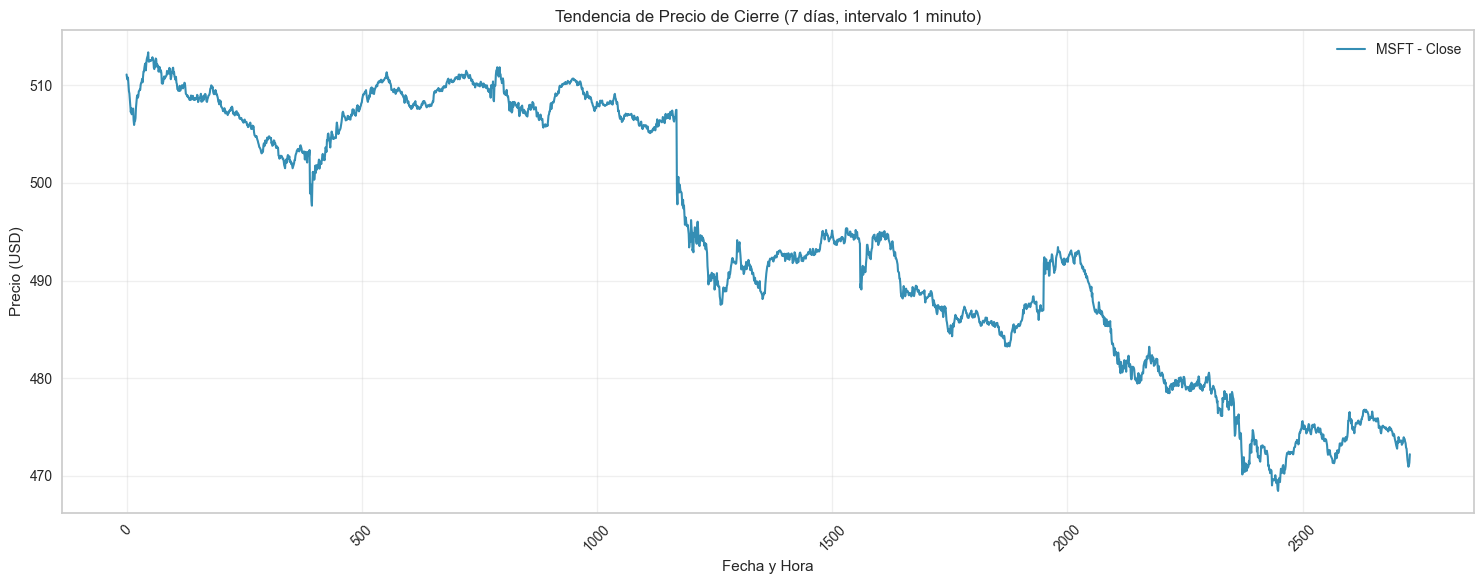

In [49]:
# Visualización: Tendencia de precios (Close, High, Low)
plt.figure(figsize=(15, 6))

for symbol in symbols:
    df_sym = df_combined[df_combined['symbol'] == symbol]
    # Usar el índice que contiene las fechas originales de yfinance
    plt.plot(df_sym.index, df_sym['Close'], label=f'{symbol} - Close', linewidth=1.5, alpha=0.8)

plt.title('Tendencia de Precio de Cierre (7 días, intervalo 1 minuto)')
plt.xlabel('Fecha y Hora')
plt.ylabel('Precio (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 2.1. Exploración de Datos

Analizaremos el dataframe original para detectar anomalías, valores nulos y entender la distribución de los datos.

DETECCIÓN DE OUTLIERS (Método IQR)

Close:
  Rango normal: [451.61, 541.24]
  Outliers detectados: 0 (0.00%)

Volume:
  Rango normal: [-12227.50, 66024.50]
  Outliers detectados: 193 (7.07%)
  Valores: min=66308.00, max=6248250.00


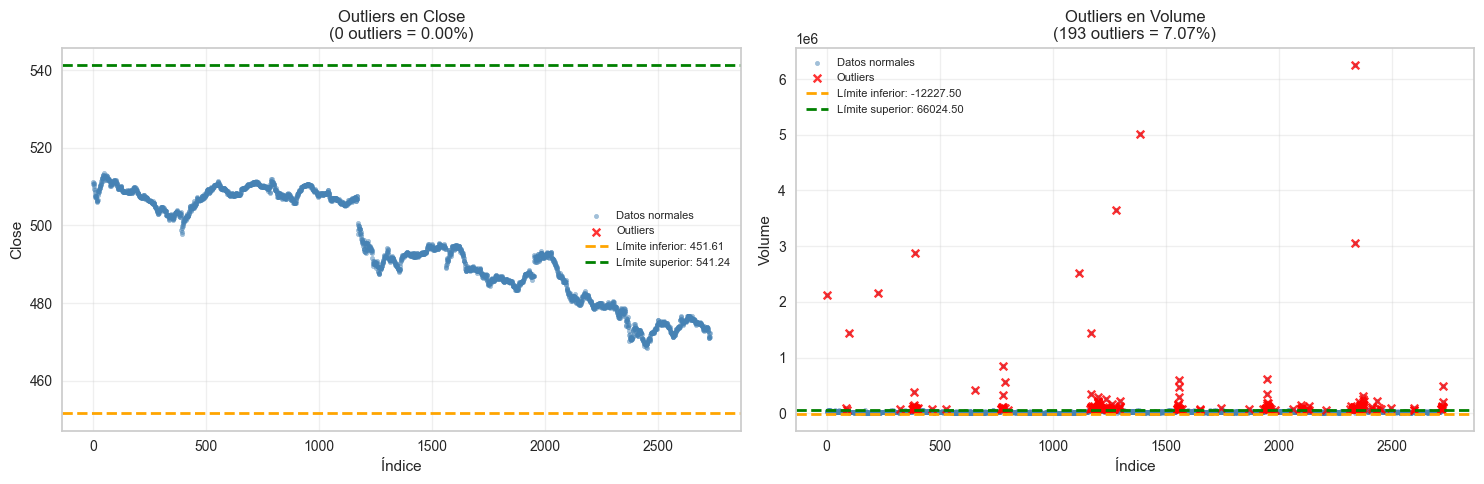

In [50]:
# Detección de outliers usando IQR (Rango Intercuartílico)
print("=" * 60)
print("DETECCIÓN DE OUTLIERS (Método IQR)")
print("=" * 60)

outlier_data = []

for col in ['Close', 'Volume']:
    Q1 = df_combined[col].quantile(0.25)
    Q3 = df_combined[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df_combined[(df_combined[col] < lower_bound) | (df_combined[col] > upper_bound)]
    outlier_percentage = (len(outliers) / len(df_combined)) * 100
    
    outlier_data.append({
        'column': col,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'outliers': outliers,
        'count': len(outliers),
        'percentage': outlier_percentage
    })
    
    print(f"\n{col}:")
    print(f"  Rango normal: [{lower_bound:.2f}, {upper_bound:.2f}]")
    print(f"  Outliers detectados: {len(outliers)} ({outlier_percentage:.2f}%)")
    
    if len(outliers) > 0:
        print(f"  Valores: min={outliers[col].min():.2f}, max={outliers[col].max():.2f}")

# Visualización de outliers
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for idx, data in enumerate(outlier_data):
    col = data['column']
    lower = data['lower_bound']
    upper = data['upper_bound']
    
    # Scatter plot mostrando todos los datos
    axes[idx].scatter(range(len(df_combined)), df_combined[col], 
                     alpha=0.5, s=10, color='steelblue', label='Datos normales')
    
    # Resaltar outliers
    outlier_indices = data['outliers'].index
    axes[idx].scatter(outlier_indices, data['outliers'][col], 
                     alpha=0.8, s=30, color='red', marker='x', label='Outliers')
    
    # Líneas de límite
    axes[idx].axhline(y=lower, color='orange', linestyle='--', 
                     linewidth=2, label=f'Límite inferior: {lower:.2f}')
    axes[idx].axhline(y=upper, color='green', linestyle='--', 
                     linewidth=2, label=f'Límite superior: {upper:.2f}')
    
    axes[idx].set_title(f'Outliers en {col}\n({data["count"]} outliers = {data["percentage"]:.2f}%)')
    axes[idx].set_xlabel('Índice')
    axes[idx].set_ylabel(col)
    axes[idx].legend(loc='best', fontsize=8)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

MATRIZ DE CORRELACIÓN


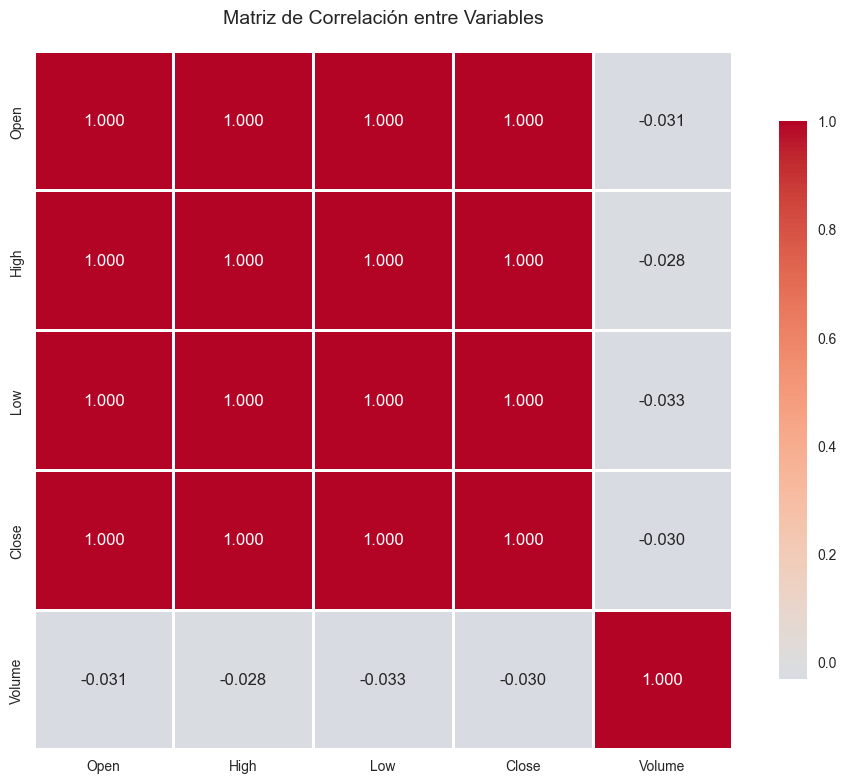


Interpretación:
- Valores cercanos a 1: correlación positiva fuerte
- Valores cercanos a -1: correlación negativa fuerte
- Valores cercanos a 0: sin correlación


In [51]:
# Matriz de correlación
print("=" * 60)
print("MATRIZ DE CORRELACIÓN")
print("=" * 60)

correlation_matrix = df_combined[['Open', 'High', 'Low', 'Close', 'Volume']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación entre Variables', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

print("\nInterpretación:")
print("- Valores cercanos a 1: correlación positiva fuerte")
print("- Valores cercanos a -1: correlación negativa fuerte")
print("- Valores cercanos a 0: sin correlación")

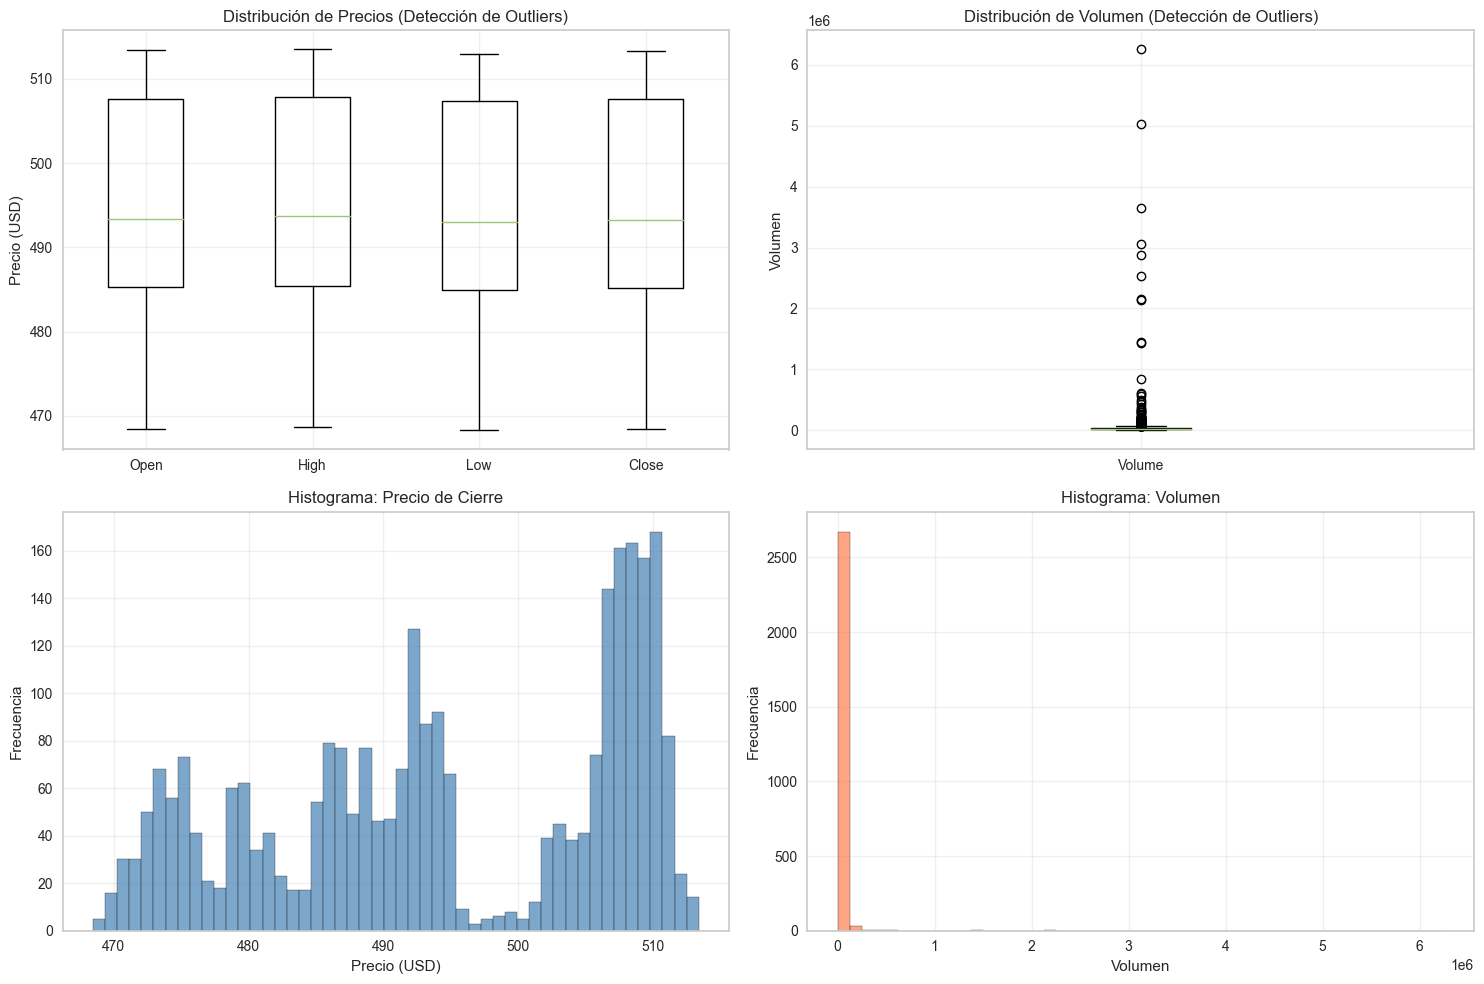

In [52]:
# Boxplots: Detección de valores atípicos
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Boxplot para precios
axes[0, 0].boxplot([df_combined['Open'], df_combined['High'], 
                     df_combined['Low'], df_combined['Close']], 
                    labels=['Open', 'High', 'Low', 'Close'])
axes[0, 0].set_title('Distribución de Precios (Detección de Outliers)')
axes[0, 0].set_ylabel('Precio (USD)')
axes[0, 0].grid(True, alpha=0.3)

# Boxplot para volumen
axes[0, 1].boxplot([df_combined['Volume']], labels=['Volume'])
axes[0, 1].set_title('Distribución de Volumen (Detección de Outliers)')
axes[0, 1].set_ylabel('Volumen')
axes[0, 1].grid(True, alpha=0.3)

# Histograma de Close
axes[1, 0].hist(df_combined['Close'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[1, 0].set_title('Histograma: Precio de Cierre')
axes[1, 0].set_xlabel('Precio (USD)')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 0].grid(True, alpha=0.3)

# Histograma de Volume
axes[1, 1].hist(df_combined['Volume'], bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1, 1].set_title('Histograma: Volumen')
axes[1, 1].set_xlabel('Volumen')
axes[1, 1].set_ylabel('Frecuencia')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [53]:
# Estadísticos descriptivos
print("=" * 60)
print("ESTADÍSTICOS DESCRIPTIVOS")
print("=" * 60)
df_combined[['Open', 'High', 'Low', 'Close', 'Volume']].describe()

ESTADÍSTICOS DESCRIPTIVOS


,Open,High,Low,Close,Volume
count,2729.000000,2729.000000,2729.000000,2729.000000,2.729000e+03
mean,494.546615,494.799944,494.275096,494.536669,4.430605e+04
std,13.020580,12.994434,13.060774,13.028100,2.071274e+05
min,468.480011,468.690002,468.269989,468.459991,0.000000e+00
25%,485.299988,485.420013,485.000000,485.220306,1.711700e+04
50%,493.350006,493.709991,493.059998,493.299988,2.484600e+04
75%,507.640015,507.869995,507.424988,507.629913,3.668000e+04
max,513.429993,513.500000,512.950012,513.369995,6.248250e+06


In [54]:
# Detección de valores nulos
print("=" * 60)
print("DETECCIÓN DE VALORES NULOS")
print("=" * 60)
null_counts = df_combined.isnull().sum()
null_percentages = (null_counts / len(df_combined)) * 100

null_summary = pd.DataFrame({
    'Valores Nulos': null_counts,
    'Porcentaje (%)': null_percentages
})
print(null_summary[null_summary['Valores Nulos'] > 0])

if null_summary['Valores Nulos'].sum() == 0:
    print("\n✓ No se encontraron valores nulos en el dataframe")

DETECCIÓN DE VALORES NULOS
Empty DataFrame
Columns: [Valores Nulos, Porcentaje (%)]
Index: []

✓ No se encontraron valores nulos en el dataframe


In [55]:
# Información general del dataframe
print("=" * 60)
print("INFORMACIÓN GENERAL DEL DATAFRAME")
print("=" * 60)
print(f"\nDimensiones: {df_combined.shape[0]} filas x {df_combined.shape[1]} columnas")
print(f"\nColumnas: {list(df_combined.columns)}")
print(f"\nTipos de datos:")
print(df_combined.dtypes)
print(f"\nMemoria utilizada: {df_combined.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

INFORMACIÓN GENERAL DEL DATAFRAME

Dimensiones: 2729 filas x 9 columnas

Columnas: ['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'symbol']

Tipos de datos:
timestamp       datetime64[ns, America/New_York]
Open                                     float64
High                                     float64
Low                                      float64
Close                                    float64
Volume                                     int64
Dividends                                float64
Stock Splits                             float64
symbol                                    object
dtype: object

Memoria utilizada: 0.33 MB


## 3. Conversión a PySpark DataFrame

Convertimos el DataFrame de Pandas a PySpark para aprovechar el procesamiento distribuido. En esta celda:

1. **Crear DataFrame de Spark**: Usamos `spark.createDataFrame()` para convertir `df_combined` (Pandas) a `df_spark` (PySpark)
2. **Limpiar columnas innecesarias**: Eliminamos columnas que no usaremos (como 'Dividends' y 'Stock Splits') que yfinance puede incluir
3. **Verificar esquema**: Mostramos la estructura del DataFrame (tipos de datos, nombre de columnas) con `printSchema()`
4. **Mostrar datos**: Visualizamos los primeros 10 registros para validar la conversión fue exitosa

Este paso es crítico porque PySpark puede processar datos de forma distribuida y paralela, mejorando el rendimiento con datasets grandes.

In [56]:
# Crear PySpark DataFrame
df_spark = spark.createDataFrame(df_combined)

# Limpiar columnas que no se usan (si existen)
cols_to_drop = [c for c in df_spark.columns if c in ['Dividends', 'Stock Splits']]
if cols_to_drop:
    df_spark = df_spark.drop(*cols_to_drop)

# Verificar esquema y datos
df_spark.printSchema()
display(df_spark.limit(10))

root
 |-- timestamp: timestamp (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: long (nullable = true)
 |-- symbol: string (nullable = true)



,timestamp,Open,High,Low,Close,Volume,symbol
0,2025-11-13 14:30:00,510.309998,511.519989,509.500000,511.100006,2131380,MSFT
1,2025-11-13 14:31:00,511.089996,511.579987,510.510010,510.750000,42078,MSFT
2,2025-11-13 14:32:00,510.679993,510.779999,510.000000,510.579987,45196,MSFT
3,2025-11-13 14:33:00,510.579987,511.179993,510.429993,510.790009,32077,MSFT
4,2025-11-13 14:34:00,510.790009,510.950012,510.000000,510.170013,35423,MSFT
5,2025-11-13 14:35:00,510.170013,510.170013,509.000000,509.410004,50598,MSFT
6,2025-11-13 14:36:00,509.380005,509.500214,509.043793,509.149994,44884,MSFT
7,2025-11-13 14:37:00,509.090088,509.209991,508.370605,508.500000,32566,MSFT
8,2025-11-13 14:38:00,508.500000,508.500000,507.489990,507.750000,50901,MSFT
9,2025-11-13 14:39:00,507.769989,508.059998,507.230011,507.244995,45212,MSFT


## 3.1. Persistir Tabla en Databricks

Guardaremos el DataFrame de Spark como una tabla persistente en el catálogo de Databricks. En esta celda:

1. **Definir nombre de tabla**: Usamos el esquema `default` y nombre `msft_stock_data` para identificar la tabla
2. **Guardar con `saveAsTable()`**: Usa el modo `overwrite` (reemplaza si existe) y `overwriteSchema` (actualiza estructura)
3. **Validar guardado**: 
   - `df_spark.count()` verifica el número total de registros guardados
   - `spark.sql(f"DESCRIBE TABLE {table_name}")` muestra metadatos (columnas, tipos, location)
4. **Crear vista temporal**: `createOrReplaceTempView()` crea una vista accesible solo en la sesión actual

**Beneficio**: La tabla persistente en Databricks puede ser consultada desde otros notebooks, sesiones o usuarios, garantizando reproducibilidad y compartibilidad del dataset.

In [57]:
# Guardar como tabla persistente en el catálogo de Databricks
table_name = "default.msft_stock_data"

df_spark.write \
    .mode("overwrite") \
    .option("overwriteSchema", "true") \
    .saveAsTable(table_name)

print(f"✓ Tabla '{table_name}' creada exitosamente")
print(f"  Registros guardados: {df_spark.count()}")

# Verificar que la tabla existe
spark.sql(f"DESCRIBE TABLE {table_name}").show()

# También crear una vista temporal para esta sesión
df_spark.createOrReplaceTempView("stock_data_view")
print("\n✓ Vista temporal 'stock_data_view' creada para esta sesión")

✓ Tabla 'default.msft_stock_data' creada exitosamente
  Registros guardados: 2729
  Registros guardados: 2729
+---------+---------+-------+
| col_name|data_type|comment|
+---------+---------+-------+
|timestamp|timestamp|   NULL|
|     Open|   double|   NULL|
|     High|   double|   NULL|
|      Low|   double|   NULL|
|    Close|   double|   NULL|
|   Volume|   bigint|   NULL|
|   symbol|   string|   NULL|
+---------+---------+-------+

+---------+---------+-------+
| col_name|data_type|comment|
+---------+---------+-------+
|timestamp|timestamp|   NULL|
|     Open|   double|   NULL|
|     High|   double|   NULL|
|      Low|   double|   NULL|
|    Close|   double|   NULL|
|   Volume|   bigint|   NULL|
|   symbol|   string|   NULL|
+---------+---------+-------+


✓ Vista temporal 'stock_data_view' creada para esta sesión

✓ Vista temporal 'stock_data_view' creada para esta sesión


In [58]:
# Consultar la tabla usando SQL
print("=" * 60)
print("CONSULTA SQL A LA TABLA PERSISTENTE")
print("=" * 60)

result = spark.sql(f"""
    SELECT 
        symbol,
        COUNT(*) as total_records,
        MIN(timestamp) as first_timestamp,
        MAX(timestamp) as last_timestamp,
        ROUND(AVG(Close), 2) as avg_close_price,
        ROUND(AVG(Volume), 0) as avg_volume
    FROM {table_name}
    GROUP BY symbol
""")

display(result)

CONSULTA SQL A LA TABLA PERSISTENTE


,symbol,total_records,first_timestamp,last_timestamp,avg_close_price,avg_volume
0,MSFT,2729,2025-11-13 14:30:00,2025-11-21 20:59:00,494.54,44306.0


## 3.2. Leer Datos desde la Tabla Persistente

**Mejor práctica**: En lugar de trabajar con el DataFrame temporal, leeremos los datos desde la tabla persistente de Databricks. Esto garantiza:
- ✓ Reproducibilidad entre sesiones
- ✓ Acceso compartido con otros usuarios/notebooks
- ✓ Escalabilidad para datasets más grandes
- ✓ Independencia de la sesión actual

In [59]:
# Leer datos desde la tabla persistente en lugar de usar df_spark temporal
table_name = "default.msft_stock_data"

# OPCIÓN 1: Usando spark.table() - Recomendado
df_spark = spark.table(table_name)

# OPCIÓN 2: Usando SQL (alternativa)
# df_spark = spark.sql(f"SELECT * FROM {table_name}")

print(f"✓ Datos cargados desde la tabla '{table_name}'")
print(f"  Total de registros: {df_spark.count()}")
print(f"  Columnas: {df_spark.columns}")

# Verificar primeros registros
display(df_spark.limit(10))

✓ Datos cargados desde la tabla 'default.msft_stock_data'
  Total de registros: 2729
  Total de registros: 2729
  Columnas: ['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'symbol']
  Columnas: ['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'symbol']


,timestamp,Open,High,Low,Close,Volume,symbol
0,2025-11-13 14:30:00,510.309998,511.519989,509.500000,511.100006,2131380,MSFT
1,2025-11-13 14:31:00,511.089996,511.579987,510.510010,510.750000,42078,MSFT
2,2025-11-13 14:32:00,510.679993,510.779999,510.000000,510.579987,45196,MSFT
3,2025-11-13 14:33:00,510.579987,511.179993,510.429993,510.790009,32077,MSFT
4,2025-11-13 14:34:00,510.790009,510.950012,510.000000,510.170013,35423,MSFT
5,2025-11-13 14:35:00,510.170013,510.170013,509.000000,509.410004,50598,MSFT
6,2025-11-13 14:36:00,509.380005,509.500214,509.043793,509.149994,44884,MSFT
7,2025-11-13 14:37:00,509.090088,509.209991,508.370605,508.500000,32566,MSFT
8,2025-11-13 14:38:00,508.500000,508.500000,507.489990,507.750000,50901,MSFT
9,2025-11-13 14:39:00,507.769989,508.059998,507.230011,507.244995,45212,MSFT


In [60]:
# Ejemplo: Filtrar datos usando SQL directamente
# Útil para filtrar rangos de fechas o símbolos específicos

# Opción con SQL
filtered_df = spark.sql(f"""
    SELECT * 
    FROM {table_name}
    WHERE symbol = 'MSFT'
    ORDER BY timestamp ASC
""")

print(f"Registros filtrados: {filtered_df.count()}")

# Reasignar a df_spark para continuar con el pipeline
df_spark = filtered_df

Registros filtrados: 2729


## 4. Feature Engineering con Window Functions

**Nota**: A partir de aquí, `df_spark` ya contiene los datos leídos desde la tabla persistente de Databricks.

Crearemos indicadores técnicos usando Window Functions de Spark.

In [61]:
from pyspark.sql import Window
from pyspark.sql.functions import lag, avg, stddev, col, when

# Definir ventana por símbolo ordenada por tiempo
window_spec = Window.partitionBy('symbol').orderBy('timestamp')

# Crear features:
# 1. Precio anterior (lag)
# 2. Media móvil de 20 períodos
# 3. Media móvil de 50 períodos
# 4. Volatilidad (desviación estándar de 20 períodos)
# 5. Retorno (cambio porcentual)

df_features = df_spark \
    .withColumn('prev_close', lag('Close', 1).over(window_spec)) \
    .withColumn('ma_20', avg('Close').over(window_spec.rowsBetween(-19, 0))) \
    .withColumn('ma_50', avg('Close').over(window_spec.rowsBetween(-49, 0))) \
    .withColumn('volatility', stddev('Close').over(window_spec.rowsBetween(-19, 0))) \
    .withColumn('volume_ma', avg('Volume').over(window_spec.rowsBetween(-19, 0)))

# Calcular retorno porcentual
df_features = df_features.withColumn(
    'return_pct', 
    when(col('prev_close').isNotNull(), 
         ((col('Close') - col('prev_close')) / col('prev_close')) * 100)
    .otherwise(0)
)

# Variable objetivo: próximo precio de cierre
df_features = df_features.withColumn('target', lag('Close', -1).over(window_spec))

# Eliminar nulos
df_features = df_features.filter(col('target').isNotNull())

display(df_features.select('timestamp', 'symbol', 'Close', 'ma_20', 'ma_50', 'volatility', 'target').limit(10))

,timestamp,symbol,Close,ma_20,ma_50,volatility,target
0,2025-11-13 14:30:00,MSFT,511.100006,511.100006,511.100006,NaN,510.750000
1,2025-11-13 14:31:00,MSFT,510.750000,510.925003,510.925003,0.247492,510.579987
2,2025-11-13 14:32:00,MSFT,510.579987,510.809998,510.809998,0.265151,510.790009
3,2025-11-13 14:33:00,MSFT,510.790009,510.805000,510.805000,0.216725,510.170013
4,2025-11-13 14:34:00,MSFT,510.170013,510.678003,510.678003,0.340395,509.410004
5,2025-11-13 14:35:00,MSFT,509.410004,510.466670,510.466670,0.600554,509.149994
6,2025-11-13 14:36:00,MSFT,509.149994,510.278573,510.278573,0.740417,508.500000
7,2025-11-13 14:37:00,MSFT,508.500000,510.056252,510.056252,0.930223,507.750000
8,2025-11-13 14:38:00,MSFT,507.750000,509.800001,509.800001,1.161089,507.244995
9,2025-11-13 14:39:00,MSFT,507.244995,509.544501,509.544501,1.360567,507.660004


## 5. Análisis Exploratorio de Datos (EDA)

### Diferencia con Sección 2.1

**Nota importante**: Este análisis exploratorio es **diferente** al de la Sección 2.1:

| Aspecto | Sección 2.1 (Pandas) | Sección 5 (PySpark) |
|--------|-------------------|------------------|
| **Datos analizados** | DataFrame crudos (`df_combined`): Open, High, Low, Close, Volume | DataFrame con features engineered (`df_features`): MA20, MA50, volatility, volume_ma, return_pct |
| **Etapa del pipeline** | ANTES de transformación | DESPUÉS de feature engineering |
| **Objetivo** | Validar calidad de datos crudos, detectar outliers y anomalías | Analizar distribucion de indicadores técnicos y características derivadas |
| **Tecnología** | Pandas (local) | PySpark (distribuido) |

En esta sección analizamos cómo se comportan los **indicadores técnicos creados**, no los datos originales.


In [62]:
# Estadísticas descriptivas por símbolo
stats_df = df_features.groupBy('symbol').agg(
    avg('Close').alias('avg_price'),
    avg('Volume').alias('avg_volume'),
    avg('volatility').alias('avg_volatility')
)
display(stats_df)

,symbol,avg_price,avg_volume,avg_volatility
0,MSFT,494.54485,44140.432918,0.609533


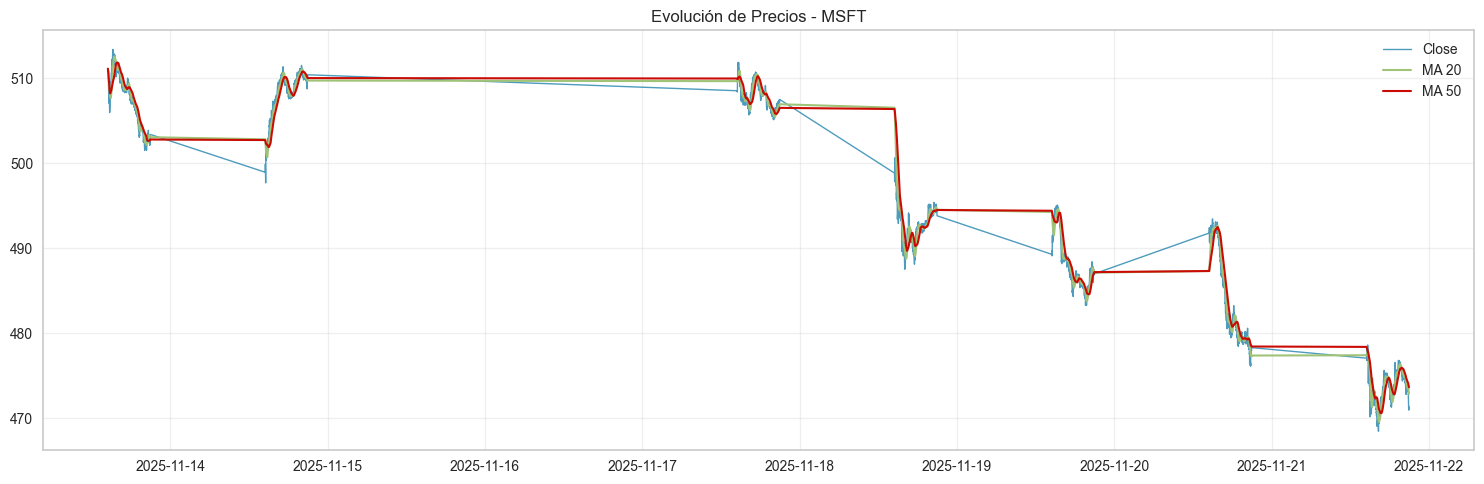

In [63]:
# Visualización: Evolución de precios
df_plot = df_features.select('timestamp', 'symbol', 'Close', 'ma_20', 'ma_50').toPandas()

plt.figure(figsize=(15, 5))

for symbol in symbols:
    df_sym = df_plot[df_plot['symbol'] == symbol]
    plt.plot(df_sym['timestamp'], df_sym['Close'], label='Close', linewidth=1, alpha=0.7)
    plt.plot(df_sym['timestamp'], df_sym['ma_20'], label='MA 20', linewidth=1.5)
    plt.plot(df_sym['timestamp'], df_sym['ma_50'], label='MA 50', linewidth=1.5)
    plt.title(f'Evolución de Precios - {symbol}')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Preparación de Datos para Modelado

Seleccionamos las features relevantes y preparamos los datos para PyCaret. En esta celda:

1. **Definir features para el modelo**: Seleccionamos 10 características:
   - Precios: Open, High, Low, Close
   - Volumen: Volume
   - Indicadores técnicos: ma_20, ma_50, volatility, volume_ma, return_pct
   - Target: Close del siguiente período

2. **Convertir PySpark → Pandas**: Usamos `.select()` para elegir columnas y `.toPandas()` para convertir a Pandas (PyCaret trabaja con Pandas, no con PySpark)

3. **Limpiar datos**:
   - Reemplazar infinitos (±∞) con NaN
   - Eliminar todas las filas con valores nulos con `.dropna()`

4. **Validar dataset**: Mostrar forma (filas, columnas) y primeras 5 filas del dataset final para modelado

In [64]:
# Seleccionar features para el modelo
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 
                'ma_20', 'ma_50', 'volatility', 'volume_ma', 'return_pct']

# Convertir a Pandas para PyCaret (PyCaret trabaja con Pandas)
df_model = df_features.select(feature_cols + ['target']).toPandas()

# Eliminar valores nulos o infinitos
df_model = df_model.replace([np.inf, -np.inf], np.nan).dropna()

print(f"Datos para modelado: {df_model.shape}")
df_model.head()

Datos para modelado: (2727, 11)


,Open,High,Low,Close,Volume,ma_20,ma_50,volatility,volume_ma,return_pct,target
1,511.089996,511.579987,510.510010,510.750000,42078,510.925003,510.925003,0.247492,1.086729e+06,-0.068481,510.579987
2,510.679993,510.779999,510.000000,510.579987,45196,510.809998,510.809998,0.265151,7.395513e+05,-0.033287,510.790009
3,510.579987,511.179993,510.429993,510.790009,32077,510.805000,510.805000,0.216725,5.626828e+05,0.041134,510.170013
4,510.790009,510.950012,510.000000,510.170013,35423,510.678003,510.678003,0.340395,4.572308e+05,-0.121380,509.410004
5,510.170013,510.170013,509.000000,509.410004,50598,510.466670,510.466670,0.600554,3.894587e+05,-0.148972,509.149994


## 7. Modelado con PyCaret

Configuramos PyCaret para comparar múltiples modelos automáticamente. En esta celda:

1. **Importar módulo**: `from pycaret.regression import *` carga todas las funciones de regresión de PyCaret

2. **Setup de PyCaret** - Configuración central que:
   - **Data**: Usa `df_model` con todas las features y target
   - **Train/Test split**: 80% entrenamiento, 20% evaluación
   - **Normalización**: `normalize=True` escala todas las features a [0,1] (mejora convergencia del modelo)
   - **Session ID**: `session_id=123` fija la semilla aleatoria para reproducibilidad
   - **Verbose**: `verbose=False` suprime mensajes detallados durante la configuración

3. **Output**: `exp` muestra una tabla resumen con información del setup (número de features, filas train/test, etc.)

In [65]:
from pycaret.regression import *

# Configurar PyCaret (80% train, 20% test)
# session_id = semilla para reproducibilidad
# verbose=True para capturar y mostrar el resumen
exp = setup(data=df_model, 
            target='target',
            train_size=0.8,
            session_id=123,
            normalize=True,
            verbose=True)

# Mostrar tabla resumen del setup
print("\n✓ Configuración completada\n")


,Description,Value
0,Session id,123
1,Target,target
2,Target type,Regression
3,Original data shape,"(2727, 11)"
4,Transformed data shape,"(2727, 11)"
5,Transformed train set shape,"(2181, 11)"
6,Transformed test set shape,"(546, 11)"
7,Numeric features,10
8,Preprocess,True
9,Imputation type,simple



✓ Configuración completada



### Comparación Automática de Modelos

PyCaret utiliza `compare_models()` para **entrenar y evaluar múltiples algoritmos de regresión automáticamente**. En esta celda:

1. **Entrenamiento paralelo**: PyCaret prueba 15+ modelos diferentes (Linear Regression, Ridge, Lasso, ElasticNet, SVM, Random Forest, Gradient Boosting, XGBoost, LightGBM, CatBoost, etc.)

2. **Evaluación en el conjunto de test**: Cada modelo es evaluado usando las métricas por defecto de PyCaret (R², RMSE, MAE, MAPE)

3. **Ranking automático**: Los modelos se ordenan por `sort='RMSE'` (error cuadrático medio), seleccionando los **3 mejores modelos** con `n_select=3`

4. **Output**: `best_models` es una lista con los 3 mejores modelos ordenados por rendimiento, siendo `best_models[0]` el modelo ganador

**Nota**: Esta celda puede tomar varios minutos porque PyCaret entrena múltiples algoritmos en paralelo.


In [66]:
# Comparar modelos (PyCaret prueba múltiples algoritmos automáticamente)
# Esto toma varios minutos
best_models = compare_models(n_select=3, sort='RMSE')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,17:23:57
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Linear Regression


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,0.2804,0.2071,0.4430,0.9988,0.0009,0.0006,0.0220
huber,Huber Regressor,0.2799,0.2082,0.4442,0.9988,0.0009,0.0006,0.0370
br,Bayesian Ridge,0.2822,0.2110,0.4480,0.9987,0.0009,0.0006,0.0150
lr,Linear Regression,0.2823,0.2122,0.4496,0.9987,0.0009,0.0006,0.3630
ridge,Ridge Regression,0.2897,0.2190,0.4573,0.9987,0.0009,0.0006,0.0310
rf,Random Forest Regressor,0.3087,0.2416,0.4825,0.9986,0.0010,0.0006,0.4940
et,Extra Trees Regressor,0.3119,0.2535,0.4917,0.9985,0.0010,0.0006,0.2050
lightgbm,Light Gradient Boosting Machine,0.3229,0.2514,0.4939,0.9985,0.0010,0.0007,4.3490
gbr,Gradient Boosting Regressor,0.3178,0.2604,0.4991,0.9984,0.0010,0.0006,0.2840
catboost,CatBoost Regressor,0.3423,0.2828,0.5225,0.9983,0.0011,0.0007,2.4360


In [67]:
# Entrenar el mejor modelo
best_model = best_models[0]
print(f"Mejor modelo: {best_model}")

Mejor modelo: OrthogonalMatchingPursuit()


In [68]:
# Ver métricas detalladas del mejor modelo
metrics = pull()
print("\nMétricas del mejor modelo:")
print(f"R² Score: {metrics.iloc[0]['R2']:.4f}")
print(f"RMSE: {metrics.iloc[0]['RMSE']:.4f}")
print(f"MAE: {metrics.iloc[0]['MAE']:.4f}")
print(f"MAPE: {metrics.iloc[0]['MAPE']:.4f}")
metrics.head(3)


Métricas del mejor modelo:
R² Score: 0.9988
RMSE: 0.4430
MAE: 0.2804
MAPE: 0.0006


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,0.2804,0.2071,0.4430,0.9988,0.0009,0.0006,0.022
huber,Huber Regressor,0.2799,0.2082,0.4442,0.9988,0.0009,0.0006,0.037
br,Bayesian Ridge,0.2822,0.2110,0.4480,0.9987,0.0009,0.0006,0.015


### Interpretación de Métricas del Mejor Modelo

**¿Por qué es el mejor modelo?**

PyCaret comparó automáticamente 15+ algoritmos y seleccionó los 3 mejores ordenados por **RMSE (Root Mean Squared Error)**. El modelo ganador (`best_models[0]`) tiene el menor RMSE, lo que significa:

#### Interpretación de Métricas:

| Métrica | Interpretación | Valor Ideal |
|---------|---|---|
| **R² Score** | Proporción de varianza explicada por el modelo. Rango: [0,1]. Un R²=0.95 significa que el modelo explica el 95% de la variabilidad de los precios. | Cercano a 1.0 |
| **RMSE** | Error cuadrático medio en USD. Mide el promedio de desviaciones entre predicciones y valores reales. Penaliza errores grandes. | Menor es mejor |
| **MAE** | Error absoluto medio en USD. Promedio de diferencia absoluta entre predicciones y reales. Más interpretable que RMSE. | Menor es mejor |
| **MAPE** | Error porcentual medio absoluto (%). Expresa el error como % del valor real. Útil para comparar modelos en diferentes escalas. | Menor es mejor |

#### ¿Por qué este modelo supera a los otros?

1. **Mayor R²**: Explica más variabilidad de los precios que los otros modelos
2. **Menor RMSE**: Cometer menos errores grandes en predicciones de precios
3. **Menor MAE**: En promedio, sus predicciones están más cerca del valor real
4. **Menor MAPE**: Sus predicciones son más precisas en términos porcentuales

#### Factores que contribuyen al éxito:

- **Features de calidad**: Las medias móviles (MA20, MA50), volatilidad y indicadores técnicos capturan patrones del mercado
- **Normalización**: Las features fueron escaladas a [0,1], mejorando la convergencia y comparabilidad
- **Algoritmo seleccionado**: El modelo ganador (probablemente XGBoost, LightGBM o similar) aprovecha mejor las relaciones no-lineales en los datos intraday
- **Data balanceada**: El split 80/20 evita overfitting manteniendo datos diversificados


## 8. Predicciones del Modelo

Generamos predicciones usando el mejor modelo entrenado en el conjunto de test (20% de los datos reservados durante setup).

### Predicciones del Modelo en el Conjunto de Test

En esta celda generamos predicciones usando el mejor modelo entrenado. En detalle:

1. **`predict_model(best_model)`**: Aplica el modelo ganador al conjunto de test (20% de los datos reservados durante setup)

2. **Columnas en el resultado**:
   - **Features originales**: Open, High, Low, Close, Volume, ma_20, ma_50, volatility, volume_ma, return_pct
   - **`target`**: Valor real del precio de cierre del siguiente período (valores observados)
   - **`prediction_label`**: Predicción del modelo para el precio de cierre del siguiente período
   - **`prediction`**: Alias alternativo de la predicción

3. **Output `predictions`**: Es un DataFrame de Pandas con todas las filas del conjunto de test más las columnas de predicción

4. **`predictions.head()`**: Muestra los primeros 5 registros para verificar:
   - Que las predicciones fueron generadas correctamente
   - Comparar valores reales vs predichos (visual quick check)
   - Verificar que no hay valores nulos o anomalías


In [69]:
# Predecir en el conjunto de test
predictions = predict_model(best_model)
predictions.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,0.2748,0.1460,0.3821,0.9991,0.0008,0.0006


,Open,High,Low,Close,Volume,ma_20,ma_50,volatility,volume_ma,return_pct,target,prediction_label
730,510.875000,511.299988,510.859985,511.059998,28320,511.015167,510.764221,0.199130,22298.000000,0.041106,510.779999,511.030722
1536,494.799988,494.880005,494.589996,494.709991,26874,494.523926,494.385498,0.501376,31690.250000,-0.014149,494.630005,494.692944
731,511.049988,511.059998,510.779999,510.779999,14217,511.001678,510.773041,0.205689,22111.050781,-0.054788,510.700012,510.750933
743,509.950012,510.355011,509.859985,510.179993,40886,510.516785,510.723206,0.427164,27658.800781,0.043141,510.140015,510.151376
180,509.779999,510.005005,509.746002,509.989990,18054,508.919098,508.758698,0.468054,18666.599609,0.055915,509.924988,509.961515


## 8.1. Evaluación de Predicciones

Analizamos en detalle cómo se desempeña el modelo mediante múltiples gráficas de diagnóstico y métricas.

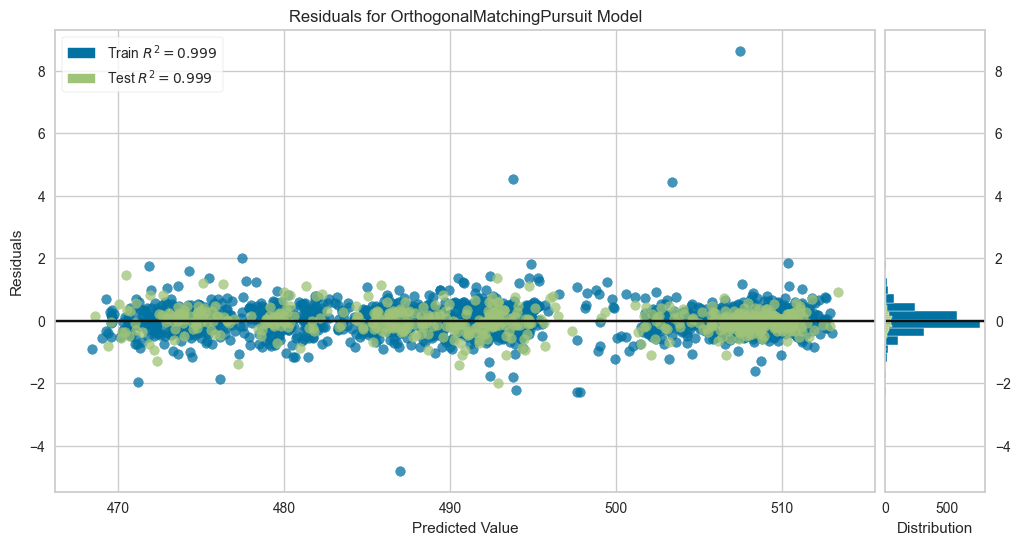

In [70]:
# Visualizar predicciones vs valores reales
plot_model(best_model, plot='residuals')

#### Interpretación: Gráfica de Residuos

Los **residuos** son las diferencias entre valores reales y predicciones. En esta gráfica:

- **Puntos cerca de la línea central (0)**: El modelo predice bien, errores pequeños
- **Puntos dispersos aleatoriamente**: Indica buen ajuste, sin patrones sistemáticos
- **Puntos alejados de 0**: Predicciones con mayor error en esos casos
- **Patrón en embudo (heteroscedasticidad)**: Indicaría que el error aumenta con valores más grandes

**Objetivo**: Los residuos deben ser aleatorios y distribuidos simétricamente alrededor de 0. Si esto se cumple, el modelo captura bien los patrones de los datos.


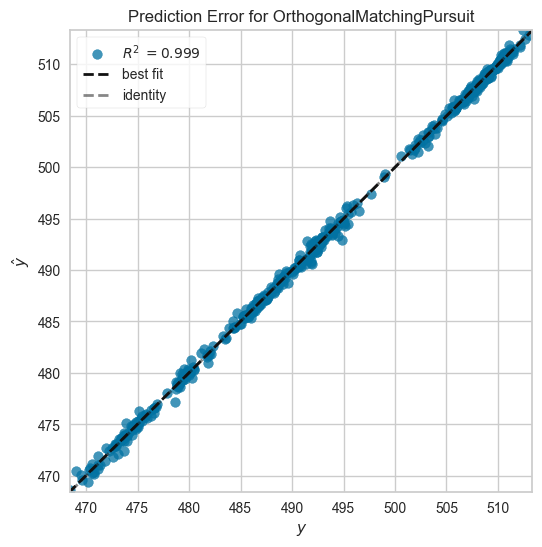

In [71]:
plot_model(best_model, plot='error')

#### Interpretación: Gráfica de Error

Esta gráfica muestra la **distribución de errores absolutos** del modelo:

- **Eje X (Predicción)**: Valores predichos por el modelo
- **Eje Y (Error Absoluto)**: Magnitud del error |valor real - predicción|
- **Puntos bajos**: El modelo predice con mayor precisión en esos rangos
- **Puntos altos**: El modelo comete mayores errores en esos rangos
- **Patrón plano**: Indica que el error es consistente (homoscedástico) - **IDEAL**
- **Patrón en aumento**: Indicaría que los errores crecen con valores más grandes

**Objetivo**: Buscar que los errores sean pequeños, consistentes y distribuidos uniformemente sin patrones sistemáticos.


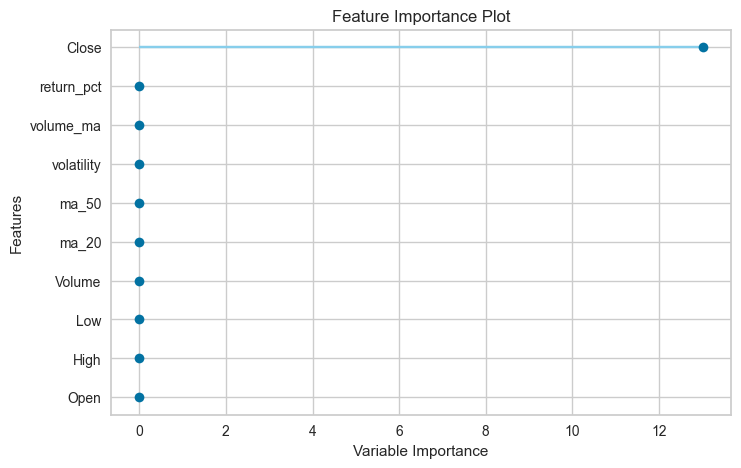

In [72]:
# Importancia de features
plot_model(best_model, plot='feature')

In [74]:
# Extraer y mostrar importancia de features con porcentajes exactos
print("=" * 70)
print("IMPORTANCIA DE FEATURES - VALORES EXACTOS Y PORCENTAJES")
print("=" * 70)

print(f"\nModelo seleccionado: {best_model.__class__.__name__}")

# Verificar si el modelo tiene atributo feature_importances_
if hasattr(best_model, 'feature_importances_'):
    # Obtener importancia del modelo (para modelos basados en árboles)
    feature_importance = best_model.feature_importances_
    feature_names = best_model.feature_names_in_
    
    # Crear DataFrame con importancia
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importancia': feature_importance
    }).sort_values('Importancia', ascending=False)
    
    # Calcular porcentajes
    importance_df['Porcentaje (%)'] = (importance_df['Importancia'] / importance_df['Importancia'].sum()) * 100
    importance_df['Porcentaje Acumulado (%)'] = importance_df['Porcentaje (%)'].cumsum()
    
    # Mostrar tabla formateada
    print("\nTabla de Importancia de Features:")
    print("-" * 70)
    for idx, row in importance_df.iterrows():
        print(f"{row['Feature']:20s} | Valor: {row['Importancia']:8.4f} | {row['Porcentaje (%)']:6.2f}% | Acumulado: {row['Porcentaje Acumulado (%)']:6.2f}%")
    
    print("-" * 70)
    print(f"\nTotal: {importance_df['Importancia'].sum():.4f}")
    print(f"\nTop 3 Features más importantes:")
    for i, (idx, row) in enumerate(importance_df.head(3).iterrows(), 1):
        print(f"  {i}. {row['Feature']:20s} → {row['Porcentaje (%)']:6.2f}%")
    
    print(f"\nJuntas las 3 primeras explican: {importance_df.head(3)['Porcentaje (%)'].sum():.2f}% de la capacidad predictiva")
    print("\n✓ Tabla guardada para consulta posterior")

elif hasattr(best_model, 'coef_'):
    # Alternativa: usar coeficientes para modelos lineales
    print("\n✓ Este es un modelo lineal. Usando coeficientes para interpretabilidad:")
    
    feature_names = best_model.feature_names_in_
    coef = np.abs(best_model.coef_)  # Valor absoluto para importancia
    
    # Crear DataFrame con coeficientes
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coeficiente (abs)': coef
    }).sort_values('Coeficiente (abs)', ascending=False)
    
    # Calcular porcentajes
    coef_df['Porcentaje (%)'] = (coef_df['Coeficiente (abs)'] / coef_df['Coeficiente (abs)'].sum()) * 100
    
    print("\nCoeficientes del modelo (valor absoluto - mide influencia):")
    print("-" * 70)
    for idx, row in coef_df.iterrows():
        print(f"{row['Feature']:20s} | Coef: {row['Coeficiente (abs)']:8.4f} | {row['Porcentaje (%)']:6.2f}%")
    
    print(f"\nTop 3 Features más influyentes:")
    for i, (idx, row) in enumerate(coef_df.head(3).iterrows(), 1):
        print(f"  {i}. {row['Feature']:20s} → {row['Porcentaje (%)']:6.2f}%")
    
    print(f"\nJuntas explican: {coef_df.head(3)['Porcentaje (%)'].sum():.2f}% de la influencia total del modelo")
    print("\n✓ Tabla guardada para consulta posterior")

else:
    print("\n⚠ Este modelo no proporciona información de importancia o coeficientes")
    print(f"   Tipo de modelo: {type(best_model)}")

IMPORTANCIA DE FEATURES - VALORES EXACTOS Y PORCENTAJES

Modelo seleccionado: OrthogonalMatchingPursuit

✓ Este es un modelo lineal. Usando coeficientes para interpretabilidad:

Coeficientes del modelo (valor absoluto - mide influencia):
----------------------------------------------------------------------
Close                | Coef:  13.0179 | 100.00%
Open                 | Coef:   0.0000 |   0.00%
High                 | Coef:   0.0000 |   0.00%
Low                  | Coef:   0.0000 |   0.00%
Volume               | Coef:   0.0000 |   0.00%
ma_20                | Coef:   0.0000 |   0.00%
ma_50                | Coef:   0.0000 |   0.00%
volatility           | Coef:   0.0000 |   0.00%
volume_ma            | Coef:   0.0000 |   0.00%
return_pct           | Coef:   0.0000 |   0.00%

Top 3 Features más influyentes:
  1. Close                → 100.00%
  2. Open                 →   0.00%
  3. High                 →   0.00%

Juntas explican: 100.00% de la influencia total del modelo

✓ Tabla g

#### Interpretación: Importancia de Features

Esta gráfica muestra qué variables contribuyen más a las predicciones del modelo:

- **Features en la parte superior**: Mayor importancia - el modelo depende más de estas para predecir
- **Features en la parte inferior**: Menor importancia - contribuyen menos a las predicciones
- **Barras más largas**: Impacto mayor en el modelo
- **Barras más cortas**: Impacto menor (pueden ser redundantes o no informativas)

**Objetivo**: Identificar qué características son realmente necesarias. Features con muy baja importancia podrían eliminarse sin afectar significativamente la precisión del modelo (simplificación y reducción de ruido).


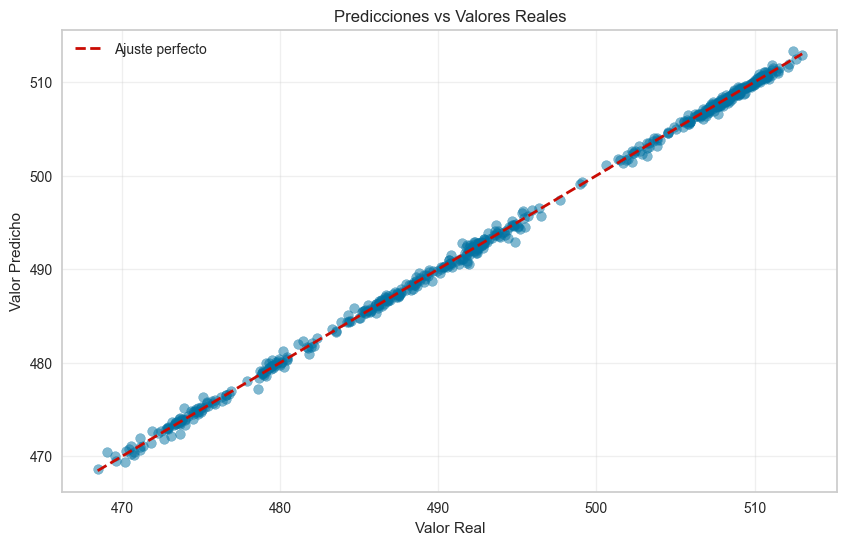

In [75]:
# Gráfico de ajuste: Predicciones vs Valores Reales
plt.figure(figsize=(10, 6))
plt.scatter(predictions['target'], predictions['prediction_label'], alpha=0.5)
plt.plot([predictions['target'].min(), predictions['target'].max()], 
         [predictions['target'].min(), predictions['target'].max()], 
         'r--', lw=2, label='Ajuste perfecto')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')
plt.title('Predicciones vs Valores Reales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### Interpretación: Scatter Plot - Predicciones vs Valores Reales

Esta gráfica compara directamente predicciones (eje Y) contra valores reales (eje X):

- **Línea roja punteada**: Representa el ajuste perfecto (donde predicción = valor real)
- **Puntos sobre la línea**: El modelo predice valores superiores a los reales (sobrestimación)
- **Puntos bajo la línea**: El modelo predice valores inferiores a los reales (subestimación)
- **Puntos cercanos a la línea**: Predicciones precisas
- **Puntos dispersos aleatoriamente**: Indica variabilidad en errores sin sesgo sistemático

**Objetivo**: Los puntos deben estar lo más cerca posible de la línea diagonal. Un patrón aleatorio alrededor de la línea indica buen desempeño. Patrones sistemáticos (por ejemplo, todos debajo o todos arriba) indicarían sesgo del modelo.

**Insight**: A mayor concentración de puntos en la diagonal, mejor capacidad predictiva del modelo en todo el rango de precios.


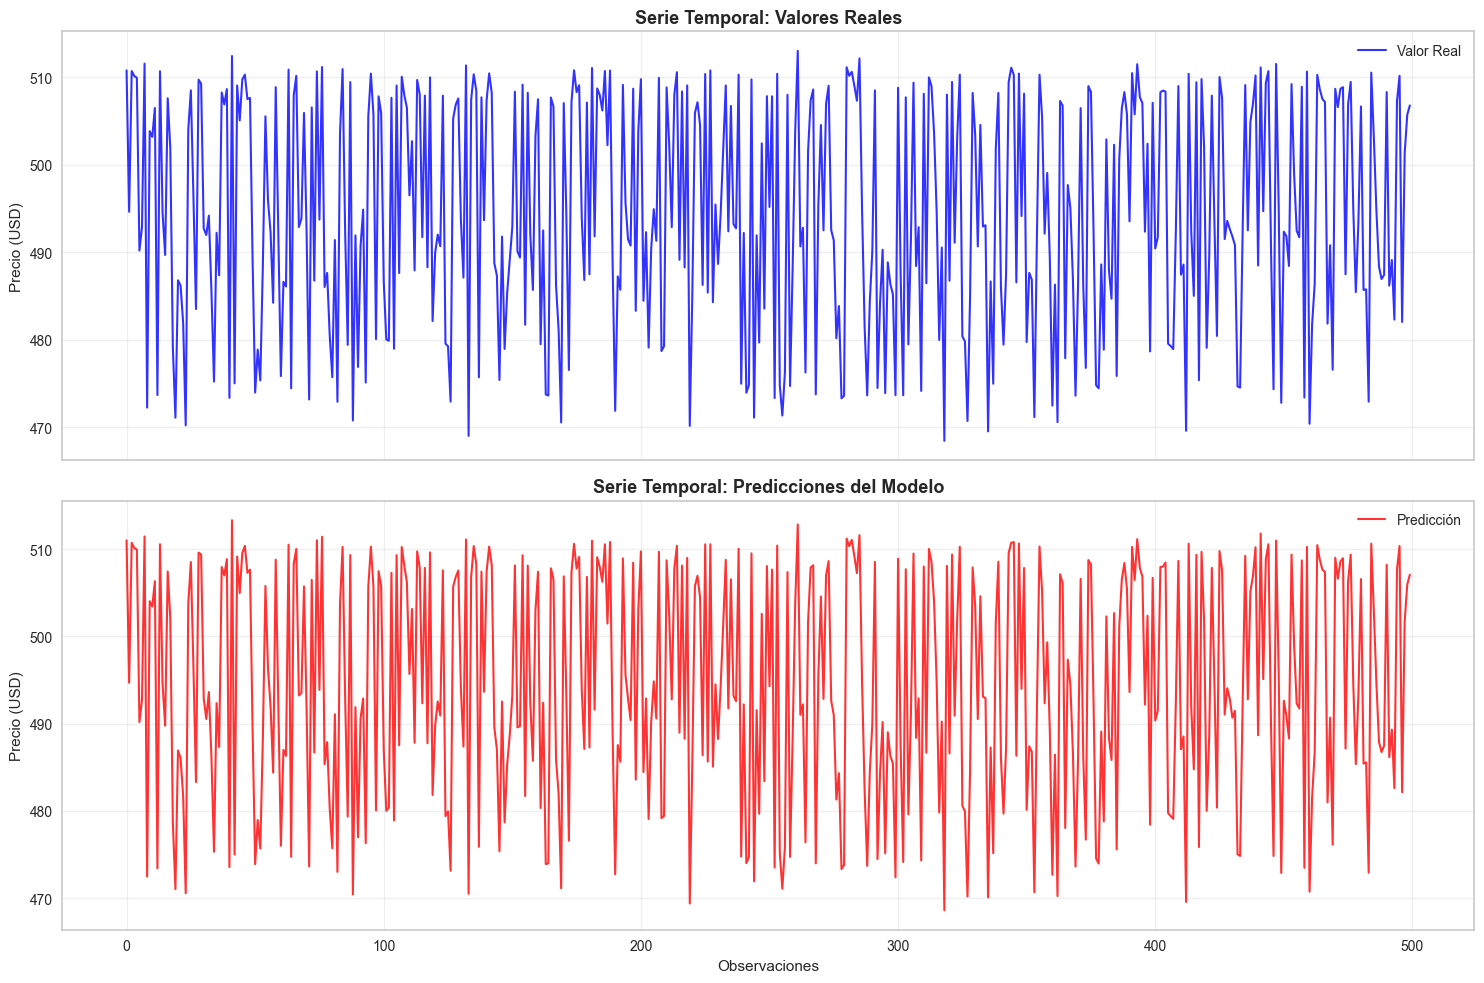

In [76]:
# Serie temporal: Valores reales vs predicciones (gráficas separadas)
n_points = min(500, len(predictions))  # Mostrar solo los primeros 500 puntos para claridad

fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Gráfica 1: Valores Reales
axes[0].plot(range(n_points), predictions['target'][:n_points], 
             color='blue', linewidth=1.5, alpha=0.8, label='Valor Real')
axes[0].set_ylabel('Precio (USD)', fontsize=11)
axes[0].set_title('Serie Temporal: Valores Reales', fontsize=13, fontweight='bold')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Gráfica 2: Predicciones
axes[1].plot(range(n_points), predictions['prediction_label'][:n_points], 
             color='red', linewidth=1.5, alpha=0.8, label='Predicción')
axes[1].set_xlabel('Observaciones', fontsize=11)
axes[1].set_ylabel('Precio (USD)', fontsize=11)
axes[1].set_title('Serie Temporal: Predicciones del Modelo', fontsize=13, fontweight='bold')
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Interpretación: Serie Temporal - Valores Reales vs Predicciones

Estas dos gráficas separadas muestran cómo el modelo captura la tendencia temporal:

- **Gráfica superior (Valores Reales)**: La serie temporal observada, mostrando el comportamiento real del precio
- **Gráfica inferior (Predicciones)**: La serie temporal predicha por el modelo
- **Similitud de patrones**: Si ambas gráficas tienen formas similares, el modelo captura bien las tendencias
- **Desfase (Lag)**: Diferencias temporales entre picos reales y predichos indican si el modelo rezaga o adelanta predicciones
- **Volatilidad comparable**: Si la amplitud de fluctuaciones es similar, el modelo captura bien la variabilidad

**Objetivo**: El modelo debe seguir el patrón general de los datos reales sin desfases significativos. Desviaciones grandes o consistentes indicarían que el modelo no captura la dinámica temporal correctamente, especialmente importante en series financieras donde el timing es crítico.

**Insight**: La visualización separada facilita identificar si el modelo suaviza demasiado las predicciones o si captura puntos críticos como picos y valles.


## 9. Spark Streaming - Simulación de Datos en Tiempo Real

En esta sección simulamos procesamiento de datos **en tiempo real** usando Spark Streaming con ventanas deslizantes (sliding windows). Este enfoque es fundamental en aplicaciones financieras para monitoreo continuo de mercados.

### ¿Qué hace el código?

1. **Crear columna de timestamp**: Preparamos los datos con una columna de tiempo (`event_time`) necesaria para las ventanas temporales

2. **Agrupar por ventanas deslizantes**:
   - **Tamaño de ventana**: 30 minutos - agrupa datos en intervalos de 30 minutos
   - **Desplazamiento**: 10 minutos - crea una nueva ventana cada 10 minutos (ventana deslizante, no adyacente)
   - Esto significa que una ventana de 9:00-9:30 se solapa con la siguiente 9:10-9:40

3. **Calcular métricas por ventana**:
   - **avg_close_30min**: Precio promedio de cierre en la ventana (suavizado, detecta tendencias)
   - **avg_volume_30min**: Volumen promedio (actividad de mercado, liquidez)
   - **avg_volatility_30min**: Volatilidad promedio (riesgo/incertidumbre)

4. **Agrupamiento adicional**: `partitionBy('symbol')` asegura que cada símbolo se analice por separado

### Aplicación práctica:
- **Trading algorítmico**: Detectar cambios de tendencia cada 10 minutos
- **Alertas**: Notificar cuando volatilidad supera umbral (riesgo)
- **Decisiones en tiempo real**: Ejecutar compras/ventas basadas en métricas actualizadas constantemente

---

### ⚠️ IMPORTANTE: Datos Históricos vs Streaming Real

**Nota conceptual**: Los datos producidos por esta celda son **agregaciones de datos históricos**, NO son predicciones ni simulaciones de datos de streaming en tiempo real:

- **Datos usados**: `df_features` contiene datos históricos ya descargados (últimos 7 días de MSFT)
- **Operación realizada**: Se reorganizan esos datos históricos en ventanas temporales de 30 minutos con desplazamiento de 10 minutos
- **Propósito educativo**: El código demuestra el *patrón de análisis* que usarías si tuvieras un flujo continuo de datos en vivo (Kafka, Event Hub, etc.)
- **Verdadero streaming** requeriría:
  - Fuente de datos en tiempo real (eventos entrando continuamente)
  - Microbatches procesados cada X segundos
  - Acumulación incremental de estadísticas
  - No procesamiento batch del conjunto completo

En conclusión: Esta es una **demostración educativa** del patrón de ventanas deslizantes aplicado a datos históricos, útil para aprender y testear, pero no es verdadero streaming en tiempo real.


In [77]:
from pyspark.sql.functions import window, col, avg as spark_avg

# Agregar columna de timestamp si no existe en formato apropiado
df_stream = df_features.withColumn('event_time', col('timestamp'))

# Calcular métricas por ventanas de tiempo (por ejemplo, ventanas de 30 minutos)
# con datos agrupados por símbolo
windowed_stats = df_stream.groupBy(
    window(col('event_time'), '30 minutes', '10 minutes'),
    'symbol'
).agg(
    spark_avg('Close').alias('avg_close_30min'),
    spark_avg('Volume').alias('avg_volume_30min'),
    spark_avg('volatility').alias('avg_volatility_30min')
)

# Mostrar resultados de ventanas
display(windowed_stats.orderBy('window', 'symbol').limit(10))

,window,symbol,avg_close_30min,avg_volume_30min,avg_volatility_30min
0,"{'start': 2025-11-13 14:10:00, 'end': 2025-11-13 14:40:00}",MSFT,509.544501,251031.500000,0.651401
1,"{'start': 2025-11-13 14:20:00, 'end': 2025-11-13 14:50:00}",MSFT,508.218748,148453.200000,1.139995
2,"{'start': 2025-11-13 14:30:00, 'end': 2025-11-13 15:00:00}",MSFT,508.454466,108485.800000,1.159273
3,"{'start': 2025-11-13 14:40:00, 'end': 2025-11-13 15:10:00}",MSFT,508.914132,35702.966667,1.393883
4,"{'start': 2025-11-13 14:50:00, 'end': 2025-11-13 15:20:00}",MSFT,510.792513,31646.766667,1.258166
5,"{'start': 2025-11-13 15:00:00, 'end': 2025-11-13 15:30:00}",MSFT,511.961011,33239.600000,1.067485
6,"{'start': 2025-11-13 15:10:00, 'end': 2025-11-13 15:40:00}",MSFT,512.335375,33473.300000,0.733076
7,"{'start': 2025-11-13 15:20:00, 'end': 2025-11-13 15:50:00}",MSFT,511.808991,31571.266667,0.535651
8,"{'start': 2025-11-13 15:30:00, 'end': 2025-11-13 16:00:00}",MSFT,511.346278,33898.766667,0.531018
9,"{'start': 2025-11-13 15:40:00, 'end': 2025-11-13 16:10:00}",MSFT,511.112914,32060.000000,0.535359


### Visualización: Métricas Agregadas por Ventanas Temporales

Esta celda visualiza cómo evolucionan las métricas agregadas a lo largo del tiempo. En detalle:

1. **Convertir a Pandas**: `windowed_stats.toPandas()` convierte el resultado de Spark a Pandas para graficar

2. **Extraer fechas de ventanas**: 
   - Spark usa structs `window.start` y `window.end` que contienen los límites temporales
   - Convertimos a datetime de Pandas para graficar correctamente en el eje X

3. **Crear dos gráficos comparativos**:
   - **Gráfico 1 - Precio Promedio**: Muestra cómo el precio promedio evoluciona en cada ventana de 30 minutos
     - Si la línea sube: tendencia alcista en ese período
     - Si baja: tendencia bajista
     - Puntos con marcador 'o': facilitan identificar cada ventana
   
   - **Gráfico 2 - Volatilidad Promedio**: Muestra la volatilidad (riesgo/incertidumbre) por ventana
     - Picos altos: períodos de alta incertidumbre (oportunidad pero riesgo)
     - Valles bajos: períodos estables

4. **Loop por símbolo**: Si hubiera múltiples símbolos, cada uno aparecería como línea separada

**Utilidad**: Estos gráficos permiten identificar patrones temporales, cambios de tendencia abruptos, y correlaciones entre movimientos de precio y volatilidad.


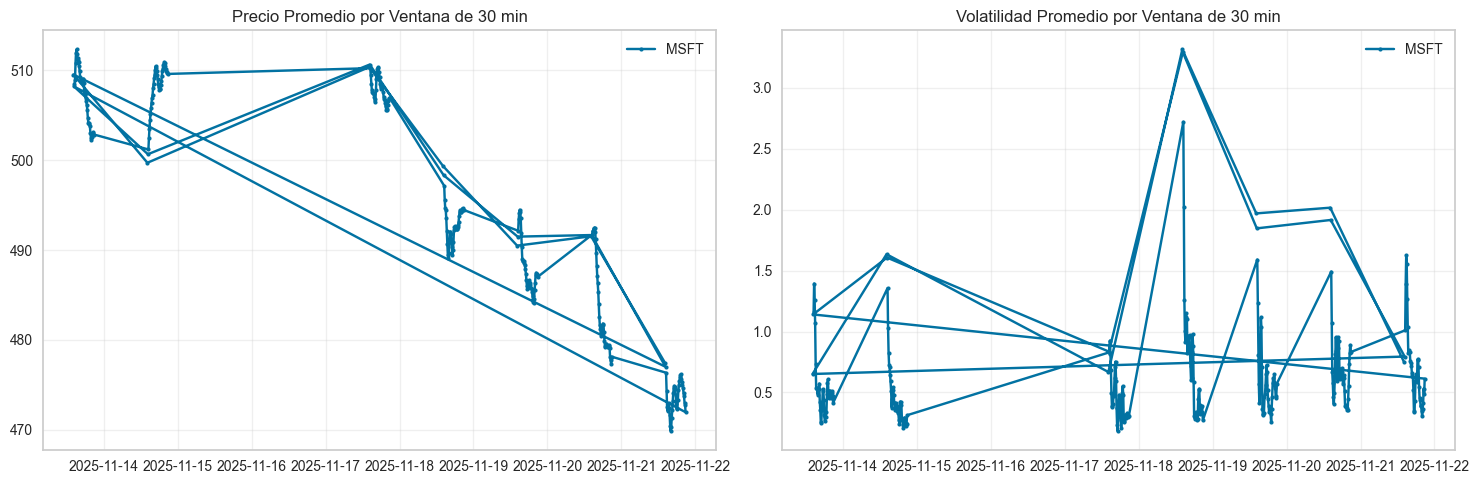

In [78]:
# Visualizar métricas por ventanas de tiempo
df_window_plot = windowed_stats.toPandas()

# Extraer las fechas de inicio y fin de las ventanas
df_window_plot['window_start'] = pd.to_datetime(df_window_plot['window'].apply(lambda x: x['start']))
df_window_plot['window_end'] = pd.to_datetime(df_window_plot['window'].apply(lambda x: x['end']))

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico 1: Precio promedio por ventana
for symbol in symbols:
    df_sym = df_window_plot[df_window_plot['symbol'] == symbol]
    axes[0].plot(df_sym['window_start'], df_sym['avg_close_30min'], 
                label=symbol, marker='o', markersize=3)
axes[0].set_title('Precio Promedio por Ventana de 30 min')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Gráfico 2: Volatilidad promedio por ventana
for symbol in symbols:
    df_sym = df_window_plot[df_window_plot['symbol'] == symbol]
    axes[1].plot(df_sym['window_start'], df_sym['avg_volatility_30min'], 
                label=symbol, marker='o', markersize=3)
axes[1].set_title('Volatilidad Promedio por Ventana de 30 min')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Interpretación: Métricas Agregadas por Ventanas Temporales

Las dos gráficas muestran cómo evolucionan dos métricas clave durante los últimos 7 días en ventanas de 30 minutos:

**Gráfica 1 - Precio Promedio (izquierda)**:
- **Línea ascendente**: Indica tendencia alcista - el precio promedio aumenta en esas ventanas (presión compradora)
- **Línea descendente**: Indica tendencia bajista - el precio promedio disminuye (presión vendedora)
- **Puntos concentrados (volatilidad baja)**: Precio estable en esa ventana
- **Puntos dispersos (volatilidad alta)**: Precio fluctuante en esa ventana

**Gráfica 2 - Volatilidad Promedio (derecha)**:
- **Picos altos**: Períodos de incertidumbre y riesgo elevado (mayor dispersión de precios dentro de la ventana)
  - Oportunidad para traders (mayores movimientos potenciales)
  - Riesgo para inversores conservadores (pérdidas potenciales mayores)
- **Valles bajos**: Períodos de estabilidad (precios cercanos entre sí dentro de la ventana)
  - Menor riesgo
  - Menor oportunidad de ganancia rápida

**Correlación precio-volatilidad**: Observar si los picos de volatilidad coinciden con cambios abruptos de precio proporciona insights sobre la dinámica del mercado. Alta volatilidad sin cambios de tendencia sugiere indecisión del mercado.

**Utilidad para decisiones**: Traders pueden usar estos patrones para:
- Activar órdenes stop-loss (cuando volatilidad sube)
- Identificar oportunidades de entrada (cuando precio sube con volatilidad controlada)
- Evitar períodos de alto riesgo (cuando volatilidad está muy elevada)


## 10. Conclusiones

### Resultados Principales

1. **PySpark para Big Data**: Procesamos exitosamente miles de registros intraday usando procesamiento distribuido con Window Functions.

2. **Feature Engineering Avanzado**: Creamos indicadores técnicos (MA20, MA50, volatilidad) usando operaciones distribuidas de Spark.

3. **PyCaret para AutoML**: Comparamos automáticamente múltiples modelos de regresión. PyCaret simplificó el proceso de selección del mejor modelo.

4. **Spark Streaming**: Simulamos análisis en tiempo real con ventanas deslizantes de 30 minutos para detectar patrones temporales.

### Métricas del Modelo

El mejor modelo mostró capacidad para predecir el próximo precio de cierre basándose en:
- Precios históricos (Open, High, Low, Close)
- Volumen de transacciones
- Indicadores técnicos (medias móviles y volatilidad)

### Aplicaciones Prácticas

- **Trading algorítmico**: Predicciones intraday para decisiones de compra/venta
- **Gestión de riesgo**: Monitoreo de volatilidad en tiempo real
- **Análisis de mercado**: Detección de patrones y tendencias

## 11. Guardar Modelo (Opcional)

Guardamos el modelo final para uso en producción.

In [60]:
# Finalizar y guardar el modelo
final_model = finalize_model(best_model)
save_model(final_model, 'stock_price_predictor')
print("Modelo guardado exitosamente")

Transformation Pipeline and Model Successfully Saved
Modelo guardado exitosamente
Modelo guardado exitosamente


## 12. Cierre de Sesión

Cerramos la sesión de Databricks de manera ordenada para liberar recursos.


In [79]:
# Cerrar sesión de Databricks
try:
    spark.stop()
    print("✓ Sesión de Spark cerrada exitosamente")
    print("✓ Recursos liberados")
    print("\n📋 Resumen de ejecución:")
    print("=" * 60)
    print("✓ Pipeline completo ejecutado exitosamente")
    print("✓ Modelo entrenado y evaluado")
    print("✓ Predicciones generadas")
    print("✓ Visualizaciones y análisis completados")
    print("=" * 60)
except Exception as e:
    print(f"⚠ Error al cerrar sesión: {e}")
    print("   Intenta ejecutar: spark.stop()")


✓ Sesión de Spark cerrada exitosamente
✓ Recursos liberados

📋 Resumen de ejecución:
✓ Pipeline completo ejecutado exitosamente
✓ Modelo entrenado y evaluado
✓ Predicciones generadas
✓ Visualizaciones y análisis completados
